In [1]:
# 导入软件包
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms 

In [2]:
# 设置随机数的种子
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### 创建Dataset

In [3]:
#图像的预处理类
#训练和预测采用不同的方法

class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    def __call__(self,img,phase='train'):
        return self.data_transform[phase](img)

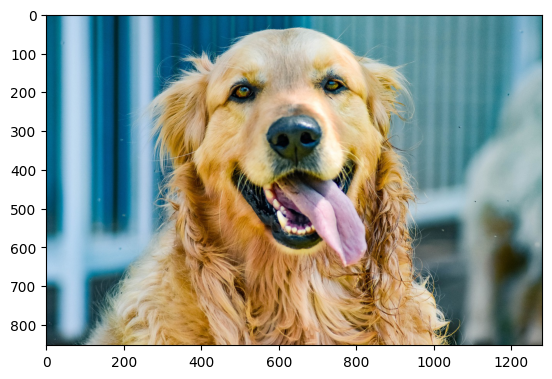

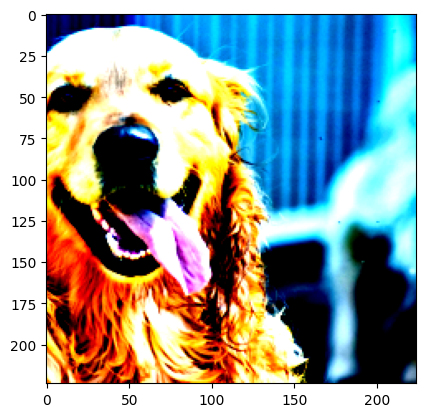

In [10]:
#确认预处理函数

#1.读入
image_file_path='./data/dog.jpg'
img = Image.open(image_file_path)

#2. 显示原图
plt.imshow(img)
plt.show()

#3.预处理
size = 224
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,'train')  #torch.Size([3, 224, 224])


#将（颜色、宽、高）-->(高度、宽、颜色)
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed,0,1)

plt.imshow(img_transformed)
plt.show()

In [25]:
#创建用于保存蚂蚁和蜜蜂的图片的文件路径的列表变量
def make_datapath_list(phase='train'):
    """
    创建用于保存数据路径的列表

    Parameters
    ----------
    phase:'train' 'val'

    Returns
    ----------
    path_list:list
        保存了数据路径的列表
    """
    rootpath = './data/hymenoptera_data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  #使用glob获得目录路径
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

#执行
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

val_list[0][28:32]
# val_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


'ants'

In [31]:
#创建友蚂蚁和蜜蜂组成的Dataset
class HymenopteraDataset(data.Dataset):
    """
    蚂蚁和蜜蜂图片的Dataset类，继承自PyTorch的Dataset类

    Attributes
    ----------
    file_list : 列表
        列表中保存了图片路径
    transform : object
        预处理类的实例
    phase : 'train' or 'test'
        指定是学习还是验证
    """

    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list = file_list
        self.transform = transform 
        self.phase = phase 

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        获取与处理完毕的图片张良数据和标签
        """
        img_path = self.file_list[index]
        img = Image.open(img_path)

        #与处理图片
        img_transformed = self.transform(img,self.phase)
        #从文件名中抽取标签
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
            
        #将标签转换成数字
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1

        return img_transformed,label
#执行
train_dataset = HymenopteraDataset(file_list=train_list,
                                   transform=ImageTransform(size,mean,std),
                                   phase='train')
val_dataset = HymenopteraDataset(file_list=val_list,
                                   transform=ImageTransform(size,mean,std),
                                   phase='val')

#确认执行结果
index = 200
train_dataset.__getitem__(index)[0].size(),train_dataset.__getitem__(index)[1]

(torch.Size([3, 224, 224]), 1)

### 创建DataLoader

In [34]:
batch_size = 32

#创建DATa Loader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,batch_size=batch_size,shuffle=False)

#保存到字典中
dataloader_dict = {'train':train_dataloader,'val':val_dataloader}

#确认
batch_iterator = iter(dataloader_dict['train'])
inputs,labels = next(batch_iterator)

print(inputs.size()) 
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1])


### 定义网络

In [37]:
#载入VGG-16
#创建VGG-16实例
use_pretrained = True 
net = models.vgg16(pretrained = use_pretrained)

#替换输出层
net.classifier[6] = nn.Linear(in_features=4096,out_features=2)

#设置为训练模式
net.train()

# print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 定义损失函数

In [38]:
criterion = nn.CrossEntropyLoss()

### 优化算法

In [41]:
#将使用迁移学习进行训练的参数保存到params_to_upgrade变量中
params_to_upgrade = []

#需要学习的参数
update_param_names = ['classifier.6.weight','classifier.6.bias']

#除了需要学习的参数外，其他参数不进行梯度计算，禁止更新
for name,param in net.named_parameters():
    # print(name) #features.0.weight
    # break
    if name in update_param_names:
        param.requires_grad = True 
        params_to_upgrade.append(param)
        print(name)
    else:
        param.requires_grad = False 

#确认
print(params_to_upgrade)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0112,  0.0081,  0.0026,  ...,  0.0004, -0.0068, -0.0093],
        [-0.0123, -0.0135,  0.0055,  ...,  0.0091,  0.0109,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 0.0110, -0.0138], requires_grad=True)]


In [42]:
optimizer = optim.SGD(params=params_to_upgrade,lr=0.001,momentum=0.9)

In [43]:
outputs = net(inputs)


In [45]:
torch.max(outputs,1)

torch.return_types.max(
values=tensor([ 0.8516,  0.3461,  0.5596,  0.1040,  0.3563, -0.9696, -0.0395, -0.9115,
         0.9599,  0.5746,  0.2488,  0.6221,  0.8116,  0.4371,  1.3277, -0.3598,
         0.1270,  0.0866,  0.6275, -0.1818, -0.2334,  0.1035, -0.1922,  0.3844,
         0.2204, -0.6663,  0.2924,  0.4805, -0.3082,  0.2860, -0.0721,  0.0212],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0]))

### 训练

In [46]:
#训练
def train_model(net,dataloader_dict,criterion,optimizer,num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch{epoch+1}/{num_epochs}')
        print('---------------')

        #在每个epoch中学习和验证循环
        for phase in ['train','val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0   #epoch的合计损失
            epoch_corrects = 0 #epoch正确数量

            #为了确认训练前的验证能力，省略epoch=0时的训练
            if (epoch == 0) and (phase == "train"):
                continue

            #载入数据并小批量循环
            for inputs,labels in tqdm(dataloader_dict[phase]):  #

                #初始化optimizer
                optimizer.zero_grad()

                #计算forward
                with torch.set_grad_enabled(phase == 'train'): #指定只在学习模式进行梯度计算
                    outputs = net(inputs)
                    loss = criterion(outputs,labels)
                    _,preds = torch.max(outputs,1)

                    #x\训练时反向传播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    #计算迭代结果
                    #更新loss总和
                    epoch_loss += loss.item() * inputs.size(0)
                    #更新正确答案总和
                    epoch_corrects += torch.sum(preds == labels.data)

                    #显示每个epoch的loss和正确率
                    epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                    epoch_acc = epoch_corrects.double()/len(dataloader_dict[phase].dataset)

                    print(f"{phase}  Loss:{epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                    
                    


In [47]:
#开始训练
num_epochs = 2
train_model(net,dataloader_dict,criterion,optimizer,num_epochs)

Epoch1/2
---------------


 20%|██        | 1/5 [00:11<00:45, 11.33s/it]

val  Loss:0.1544 Acc: 0.1111


 40%|████      | 2/5 [00:21<00:32, 10.67s/it]

val  Loss:0.1563 Acc: 0.2026


 60%|██████    | 3/5 [00:31<00:20, 10.21s/it]

val  Loss:0.1567 Acc: 0.3007


 80%|████████  | 4/5 [00:40<00:09,  9.90s/it]

val  Loss:0.1484 Acc: 0.3987


100%|██████████| 5/5 [00:47<00:00,  9.60s/it]


val  Loss:0.1128 Acc: 0.4902
Epoch2/2
---------------


 12%|█▎        | 1/8 [00:09<01:06,  9.47s/it]

train  Loss:0.0924 Acc: 0.0741


 25%|██▌       | 2/8 [00:18<00:57,  9.50s/it]

train  Loss:0.0987 Acc: 0.1440


 38%|███▊      | 3/8 [00:28<00:47,  9.54s/it]

train  Loss:0.0800 Acc: 0.2387


 50%|█████     | 4/8 [00:38<00:38,  9.75s/it]

train  Loss:0.0692 Acc: 0.3292


 62%|██████▎   | 5/8 [00:48<00:29,  9.71s/it]

train  Loss:0.0487 Acc: 0.4403


 75%|███████▌  | 6/8 [00:58<00:19,  9.79s/it]

train  Loss:0.0499 Acc: 0.5473


 88%|████████▊ | 7/8 [01:07<00:09,  9.68s/it]

train  Loss:0.0278 Acc: 0.6708


100%|██████████| 8/8 [01:13<00:00,  9.19s/it]


train  Loss:0.0200 Acc: 0.7407


 20%|██        | 1/5 [00:10<00:40, 10.02s/it]

val  Loss:0.0595 Acc: 0.1961


 40%|████      | 2/5 [00:20<00:30, 10.23s/it]

val  Loss:0.0757 Acc: 0.3791


 60%|██████    | 3/5 [00:30<00:20, 10.37s/it]

val  Loss:0.0238 Acc: 0.5817


 80%|████████  | 4/5 [00:41<00:10, 10.50s/it]

val  Loss:0.0213 Acc: 0.7778


100%|██████████| 5/5 [00:49<00:00,  9.99s/it]

val  Loss:0.0167 Acc: 0.9346
